<a href="https://colab.research.google.com/github/bucuram/foundations-of-NLP-labs/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling

Topic modeling is an unsupervised NLP technique used to identify recurring patterns of words from a collection of documents forming a text corpus. It can be useful for discovering patterns across a collection of documents, organizing large blocks of textual data, information retrieval from unstructured text, and more.

# Topic Modelling using Latent Dirichlet Allocation

LDA is a method for extracting the topics from a cospus. 

LDA is built on the premise that each document can be described by the probabilistic distribution of topics and each topic can be described by the probabilistic distribution of words.

![LDA](https://i.imgur.com/efsXXoJ.png)

In vector space, any corpus or collection of documents can be represented as a document-word matrix consisting of N documents by M words. The value of each cell in this matrix denotes the frequency of word W_j in document D_i. The LDA algorithm trains a topic model by converting this document-word matrix into two lower dimensional matrices, M1 and M2, which represent document-topic and topic-word matrices, respectively. If you take anything away about how LDA works on a mathematical level — and seriously don’t stress about this because unless you are a researcher or into computer science theory, we can just import a handy Python package, create an LDA object, and call it a day — try to understand that LDA relies on Bayes’ theory and two key probability computations to update the probability for a given word w belonging to topic t:

- p(topic t| document d) — the proportion of words in document d that are assigned to topic t

- p(word w | topic t) — captures how many documents are in topic t because of word w


# Loading the data

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models.lsimodel import LsiModel
from gensim import corpora
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt 

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
!pip install pyLDAvis
!pip install pandas --upgrade
!pip install matplotlib --upgrade

In [7]:
from sklearn.datasets import fetch_20newsgroups
# Dictionary with 'data' as key and each review as an element of list
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
documents = documents[:100]
documents

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [37]:
print(list(dataset.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


# Clean the Data

In [9]:
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

# Function to lemmatize and remove the stopwords
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stopwords.words('english') and len(i) > 3])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized = " ".join(word.replace("[^a-zA-Z#]", " ") for word in normalized.split())
    return normalized

# Implementing the function for all the documents in list_of_docs
doc_clean = [clean(doc).split() for doc in documents]
print(doc_clean[:2])

[['well', 'sure', 'story', 'seem', 'biased', 'disagree', 'statement', 'u', 'medium', 'ruin', 'israel', 'reputation', 'rediculous', 'u', 'medium', 'proisraeli', 'medium', 'world', 'lived', 'europe', 'realize', 'incidence', 'described', 'letter', 'occured', 'u', 'medium', 'whole', 'seem', 'ignore', 'them', 'u', 'subsidizing', 'israel', 'existance', 'european', 'least', 'degree', 'think', 'might', 'reason', 'report', 'clearly', 'atrocity', 'shame', 'austria', 'daily', 'report', 'inhuman', 'act', 'commited', 'israeli', 'soldier', 'blessing', 'received', 'government', 'make', 'holocaust', 'guilt', 'away', 'all', 'look', 'jew', 'treating', 'race', 'power', 'unfortunate'], ['yeah', 'expect', 'people', 'read', 'faq', 'etc', 'actually', 'accept', 'hard', 'atheism', 'need', 'little', 'leap', 'faith', 'jimmy', 'logic', 'run', 'steam', 'jim', 'sorry', 'cant', 'pity', 'you', 'jim', 'sorry', 'feeling', 'denial', 'faith', 'need', 'well', 'pretend', 'happily', 'ever', 'anyway', 'maybe', 'start', 'news

In [31]:
# Creating the dictionary id2word from our cleaned word list doc_clean
dictionary = corpora.Dictionary(doc_clean)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in doc_clean]

# Evaluation Metric

In [12]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, data, corpus, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = num_topics,
                                           random_state = 10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model,
                                        texts = data, 
                                        dictionary = dictionary,
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
start = 10; limit = 40; step = 2

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, 
                                                        data = doc_clean, corpus = corpus, 
                                                        start = start, limit = limit,
                                                        step = step)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

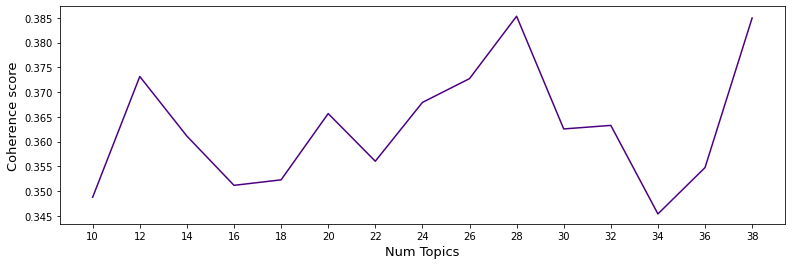

In [33]:
x = range(start, limit, step)
plt.figure(figsize = (13, 4))
plt.plot(x, coherence_values, color = 'indigo')
plt.xlabel("Num Topics", fontsize = 13)
plt.ylabel("Coherence score", fontsize = 13)
plt.xticks(x)
plt.show()

# Running LDA

In [34]:
import string
from gensim.models.ldamodel import LdaModel

# Creating the LDA model
ldamodel = LdaModel(corpus=corpus, num_topics=6, id2word=dictionary, random_state=20, passes=30)

# printing the topics
pprint(ldamodel.print_topics())

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.007*"year" + 0.006*"power" + 0.004*"vram" + 0.004*"would" + 0.004*"info" '
  '+ 0.003*"think" + 0.003*"could" + 0.003*"last" + 0.003*"people" + '
  '0.003*"certain"'),
 (1,
  '0.005*"like" + 0.005*"government" + 0.004*"know" + 0.004*"force" + '
  '0.004*"contact" + 0.004*"patch" + 0.004*"would" + 0.004*"mormon" + '
  '0.004*"bike" + 0.004*"phone"'),
 (2,
  '0.008*"file" + 0.007*"image" + 0.007*"graphic" + 0.007*"send" + '
  '0.006*"mail" + 0.006*"object" + 0.005*"also" + 0.005*"format" + '
  '0.004*"system" + 0.004*"package"'),
 (3,
  '0.005*"well" + 0.005*"adirondack" + 0.004*"john" + 0.004*"breton" + '
  '0.004*"baltimore" + 0.004*"cape" + 0.004*"providence" + 0.004*"utica" + '
  '0.004*"fredericton" + 0.004*"rochester"'),
 (4,
  '0.008*"know" + 0.006*"key" + 0.006*"would" + 0.005*"good" + 0.005*"jesus" + '
  '0.005*"like" + 0.005*"work" + 0.005*"chip" + 0.004*"cable" + 0.004*"life"'),
 (5,
  '0.010*"israel" + 0.007*"israeli" + 0.005*"thing" + 0.004*"time" + '
  '0.004*"sol

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

# pyLDAvis Visualization

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.189446  0.014208       1        1  49.518194
1      0.056889  0.002936       2        1  12.301467
5      0.038851  0.106543       3        1  11.125826
4      0.060310  0.022254       4        1  11.116462
3      0.022544 -0.117433       5        1   8.837174
0      0.010852 -0.028508       6        1   7.100878, topic_info=         Term       Freq      Total Category  logprob  loglift
22     israel  18.000000  18.000000  Default  30.0000  30.0000
205      year  19.000000  19.000000  Default  29.0000  29.0000
1330  graphic  45.000000  45.000000  Default  28.0000  28.0000
115      know  26.000000  26.000000  Default  27.0000  27.0000
23    israeli  11.000000  11.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
136      work   1.625471  17.572959   Topic6  -6.2525   0.2644
395    others   1.625411  13.212301   Topic6  -6.2526   0.5496
265    better   1.625396  12.269282   Topic6  -6.2526   0.6236
31      might   1.625339  11.669791   Topic6  -6.2526   0.6737
308   problem   1.625321   9.401607   Topic6  -6.2526   0.8898

[366 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3569      6  0.599374  2000
618       1  0.264099   416
618       5  0.528198   416
3077      5  0.863780   417
3081      5  0.854470   422
...     ...       ...   ...
205       1  0.315458  year
205       3  0.210305  year
205       5  0.105153  year
205       6  0.315458  year
3449      3  0.912850  zone

[663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 5, 4, 1])

# Word Cloud Visualization

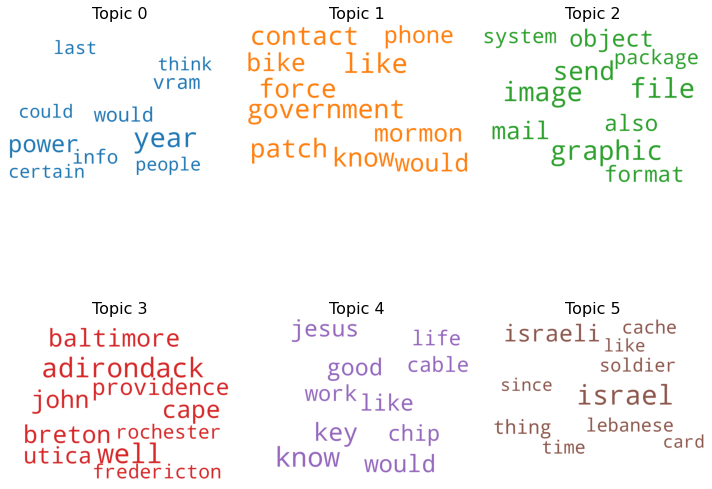

In [26]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig.savefig('word_cloud.png')
plt.show()

Further reading:

- [LDA gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)

- [LDA Paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)